# MCMC For Order 0, 1, and 2

In [3]:
using HierarchicalLattices
using MultihistogramAnalysis
using Plots
using LaTeXStrings
using ProgressMeter
using StatsBase
using DataFrames

In [4]:
function create_histogram_df(histogram_fit)
    xdata = histogram_fit.edges[1]
    ydata = histogram_fit.edges[2]

    xx = [x for _ in ydata[1:end-1] for x in xdata[1:end-1]]
    yy = [y for y in ydata[1:end-1] for x in xdata[1:end-1]]
    zz = vec(histogram_fit.weights)

    return DataFrame(
        :M => xx,
        :U => yy,
        :f => zz
    )
end

create_histogram_df (generic function with 1 method)

In [5]:
DO0 = DiamondLattice(diamond_ising_lattice(0, :infty), 0)
DO1 = DiamondLattice(diamond_ising_lattice(1, :infty), 1)
DO2 = DiamondLattice(diamond_ising_lattice(2, :infty), 2)
DO5 = DiamondLattice(diamond_ising_lattice(5, :infty), 5)

ID0 = WolffData(DO0, Float64[], Float64[], 1, 100)
ID1 = WolffData(DO1, Float64[], Float64[], 1, 100)
ID2 = WolffData(DO2, Float64[], Float64[], 1, 100)
ID5 = WolffData(DO5, Float64[], Float64[], 1, 100)

WolffData{DiamondLattice}(DiamondLattice(5, {684, 1024} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), {684, 1024} undirected Int64 metagraph with Float64 weights defined by :weight (default weight 1.0), 1.0), Float64[], Float64[], 1, 100)

In [6]:
Trange = 1:0.2:10
M0_arrays = []
M1_arrays = []
M2_arrays = []
M5_arrays = []
U0_arrays = []
U1_arrays = []
U2_arrays = []
U5_arrays = []

N0 = length(DO0.final_state.vprops)
N1 = length(DO1.final_state.vprops)
N2 = length(DO2.final_state.vprops)

12

In [7]:
nsweeps = 3000

3000

In [8]:
@showprogress for T in Trange
    # Start simulation
    wolff!(ID0, nsweeps, T; showprogress = false)
    
    push!(U0_arrays, copy(ID0.internalenergy_history))
    push!(M0_arrays, copy(ID0.magnetization_history))
    ID0.internalenergy_history = Float64[]
    ID0.magnetization_history = Float64[]
    
    
    wolff!(ID1, nsweeps, T; showprogress = false)
    push!(U1_arrays, copy(ID1.internalenergy_history))
    push!(M1_arrays, copy(ID1.magnetization_history))
    ID1.internalenergy_history = Float64[]
    ID1.magnetization_history = Float64[]
    
    
    wolff!(ID2,nsweeps, T; showprogress = false)
    push!(U2_arrays, copy(ID2.internalenergy_history))
    push!(M2_arrays, copy(ID2.magnetization_history))
    ID2.internalenergy_history = Float64[]
    ID2.magnetization_history = Float64[]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:06


Running order 5 simulation separately

In [9]:
@showprogress for T in Trange
    
    wolff!(ID5, nsweeps, T; showprogress = false)
    
    push!(U5_arrays, copy(ID5.internalenergy_history))
    push!(M5_arrays, copy(ID5.magnetization_history))
    ID5.internalenergy_history = Float64[]
    ID5.magnetization_history = Float64[]
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:31


In [10]:
function array_to_hist(Marray, Uarray; dM = 2, dU = 2)
    minM, maxM = minimum(Marray), maximum(Marray)
    minU, maxU = minimum(Uarray), maximum(Uarray)
    
    hist = fit(Histogram, (Marray, Uarray), (minM:dM:maxM+dM, minU:dU:maxU+dU))
    return create_histogram_df(hist)
end

array_to_hist (generic function with 1 method)

In [11]:
O0_hists = DataFrame[]
O1_hists = DataFrame[]
O2_hists = DataFrame[]
O5_hists = DataFrame[]

DataFrame[]

In [12]:
@showprogress for idx in eachindex(Trange)
    push!(O0_hists, array_to_hist(M0_arrays[idx], U0_arrays[idx]))
    push!(O1_hists, array_to_hist(M1_arrays[idx], U1_arrays[idx]))
    push!(O2_hists, array_to_hist(M2_arrays[idx], U2_arrays[idx]))
end

Progress: 100%|█████████████████████████████████████████| Time: 0:00:00


In [13]:
@showprogress for idx in eachindex(Trange)
    push!(O5_hists, array_to_hist(M5_arrays[idx], U5_arrays[idx]))
end

We'll use the order 5 data if needed

In [14]:
MHData0 = MultihistogramData(2, collect(Trange), O0_hists)
MHData1 = MultihistogramData(2, collect(Trange), O1_hists)
MHData2 = MultihistogramData(2, collect(Trange), O2_hists);
# MHData5 = MultihistogramData(2, collect(Trange), O5_hists);

[ Info: Generating marginal histograms and tuple iterators
[ Info: Generating marginal histograms and tuple iterators
[ Info: Generating marginal histograms and tuple iterators


In [15]:
calculate_free_energies!(MHData0);

In [16]:
calculate_free_energies!(MHData1);

In [17]:
calculate_free_energies!(MHData2);

Minimizing:  Time: 0:00:00 (42 iterations)19)


In [18]:
imrange = range(0, 2π, length = 1000);

In [19]:
function qtys_I_want(imrange, MHData)
    N = length(imrange)
    U  = zeros(ComplexF64, N)
    M  = zeros(ComplexF64, N)
    U2 = zeros(ComplexF64, N)
    M2 = zeros(ComplexF64, N)
    
    @showprogress for idx in eachindex(imrange)
        u, u2 = interpolate_energy_second_moment(1im*imrange[idx], MHData, isbeta = true, returnlinear = true)
        m, m2 = interpolate_observable_second_moment(1im*imrange[idx], :M, MHData, isbeta = true, returnlinear = true)

        U[idx]  = u
        M[idx]  = m
        U2[idx] = u2
        M2[idx] = m2
    end
    return U, M, U2, M2
end

qtys_I_want (generic function with 1 method)

In [21]:
U, M, U2, M2 = qtys_I_want(imrange, MHData2);

Progress: 100%|█████████████████████████████████████████| Time: 0:00:38


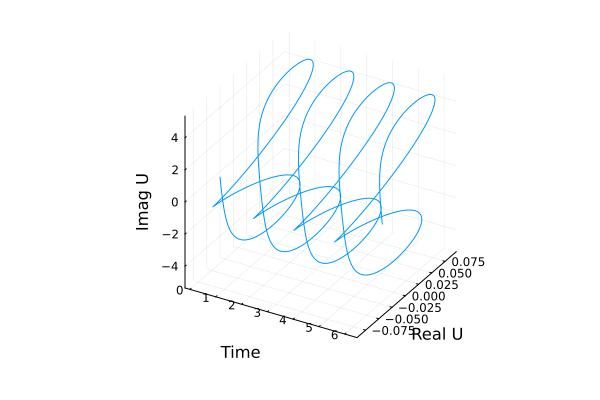

In [20]:
plot(imrange, real.(U), imag.(U), xlabel = "Time", ylabel = "Real U", zlabel = "Imag U", label = false)

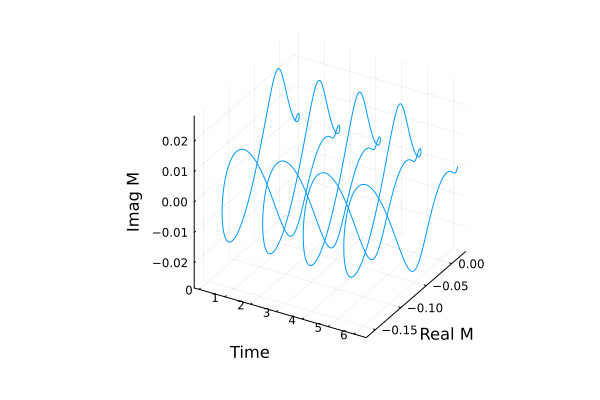

In [21]:
plot(imrange, real.(M), imag.(M), xlabel = "Time", ylabel = "Real M", zlabel = "Imag M", label = false)

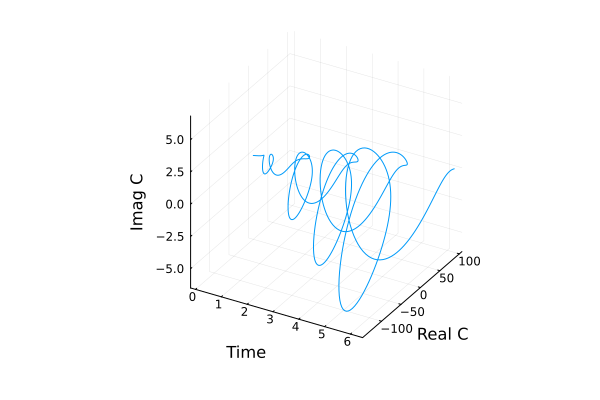

In [22]:
Cv = @. (U2 - U^2) * imrange
plot(imrange, real.(Cv), imag.(Cv), xlabel = "Time", ylabel = "Real C", zlabel = "Imag C", label = false)

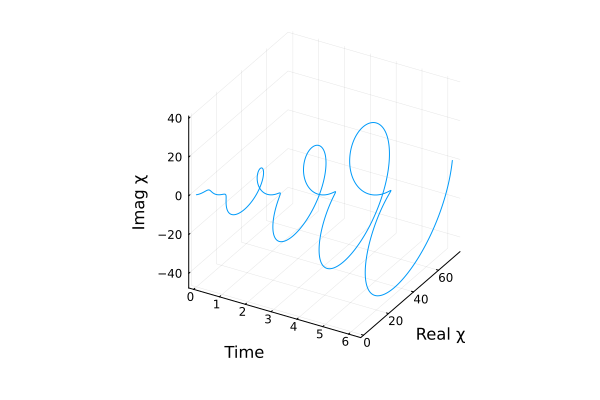

In [23]:
χ = @. (M2 - M^2) * imrange
plot(imrange, real.(χ), imag.(χ), xlabel = "Time", ylabel = "Real χ", zlabel = "Imag χ", label = false)

In [25]:
plotly()
plot(imrange, real.(Cv))

┌ Warning: backend `PlotlyBase` is not installed.
└ @ Plots ~/.julia/packages/Plots/tDHxD/src/backends.jl:43


## Analytical forms

For order 0 lattice: $-\frac{1}{2} \log(L(t)) = -\log(2) - \log|cos(t)|$. We have calculated $\log(Z)$, so we need to plot $-\frac{1}{2}\log(Z)$.

In [24]:
gr(label = false, fontfamily = "Computer Modern", dpi = 300, size = (900, 600), left_margin=3Plots.mm)

Plots.GRBackend()

In [25]:
imrange = range(0.01, 4π, step = 0.01)
DQPT_O0 = (x -> interpolate_free_energy(x, MHData0, isbeta = true)).(imrange .* 1im)
DQPT_O1 = (x -> interpolate_free_energy(x, MHData1, isbeta = true)).(imrange .* 1im)
DQPT_O2 = (x -> interpolate_free_energy(x, MHData2, isbeta = true)).(imrange .* 1im)

1256-element Vector{ComplexF64}:
 3.7120493293623427 + 0.00014723936326386923im
   3.70969592300796 + 0.00029286174218807744im
  3.705774344050866 + 0.0004352682207777961im
 3.7002857484474774 + 0.0005728960025228848im
  3.693231771702569 + 0.0007042364252993987im
  3.684614546395834 + 0.0008278529173336714im
 3.6744367252373764 + 0.0009423988659948226im
 3.6627015100536213 + 0.00104663536374974im
 3.6494126872058534 + 0.001139448786217523im
 3.6345746700511286 + 0.0012198681458461488im
  3.618192549170668 + 0.0012870821512045705im
  3.600272151215029 + 0.0013404558861333997im
  3.580820107349057 + 0.0013795470049087757im
                    ⋮
  3.606953590251026 - 0.0013227167573091302im
 3.6243164109014563 - 0.0012642582602336028im
  3.640138750566277 - 0.001192168504664165im
  3.654415057128693 - 0.0011071483202977303im
 3.6671404921288735 - 0.0010100689086774825im
 3.6783108751525497 - 0.000901955015071013im
 3.6879226365132056 - 0.0007839677532973029im
 3.6959727774247053 - 0.0006

Now we compare the analytical rate function with the Multihistogram interpolation of the rate function

In [26]:
function analytical_dqpt(x, n)
    if n == 0
        return real(-log(2) - log(cos(Complex(x)))) + log(2)
    elseif n == 1
        return abs(real(3/4 * log(2) + 1/4 * log(1 + (cos(2*Complex(x)))^2)) - log(2))
    elseif n == 2
        t = Complex(x)
        logZ = log( 2^12 * (1/8 * (1 + (cos(2*t)^4))^2 + 1/2 * (cos(2t))^4) )
        return real(-1/12 * logZ + log(2))
    end 
end

analytical_dqpt (generic function with 1 method)

In [27]:
gr(dpi = 300, fontfamily = "Computer Modern", label = false, size = (900, 600), frame = :box)
scalefontsizes(1.1)

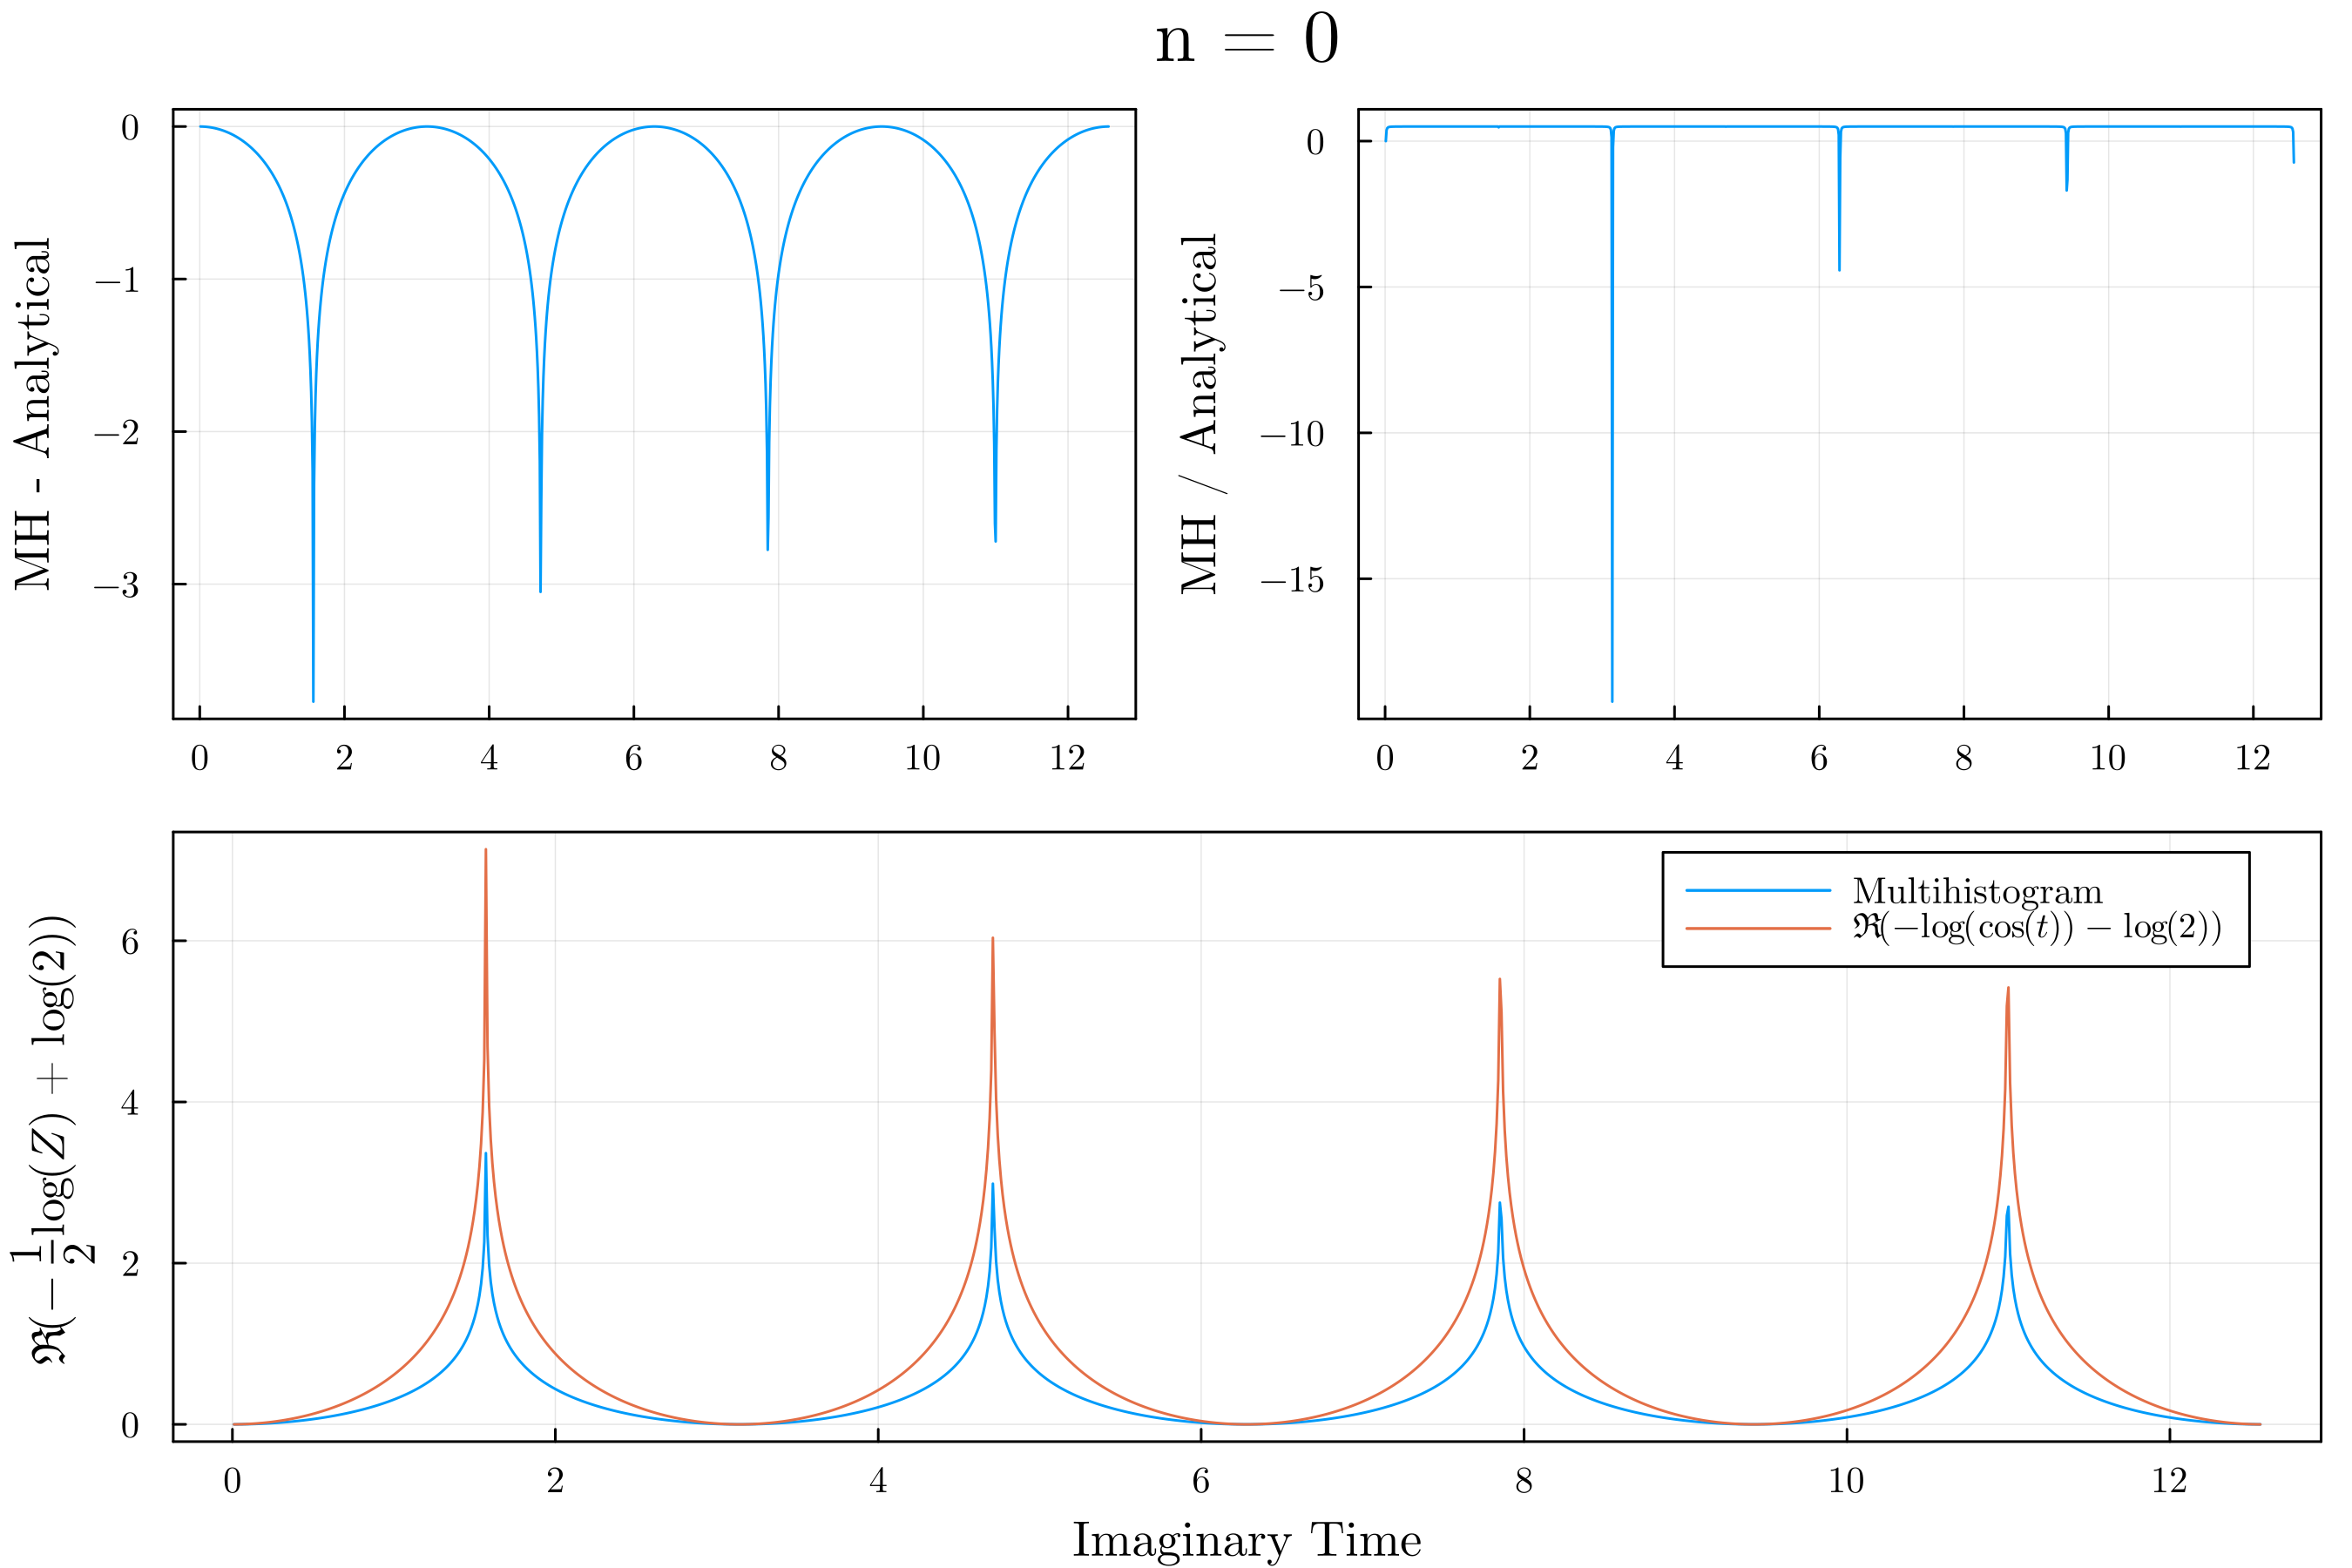

In [28]:
l = @layout [a b ; c]
MH = real.(-1/2 .* DQPT_O0 .+ log(2)) .- real.(-1/2 .* DQPT_O0 .+ log(2))[1]
AN = (x -> analytical_dqpt(x, 0)).(imrange)
fig1 = plot(imrange, MH, label = "Multihistogram", ylabel = L"\Re(-\frac{1}{2} \log(Z) + \log(2))", xlabel = "Imaginary Time")
plot!(fig1, imrange, AN, label = L"\Re(-\log(\cos(t)) - \log(2))")

diff_fig = plot(imrange, MH .- AN, ylabel = "MH - Analytical")
ratio_fig = plot(imrange, MH ./ AN, ylabel = "MH / Analytical")
order0 = plot(diff_fig, ratio_fig, fig1, layout = l, plot_title = "n = 0")

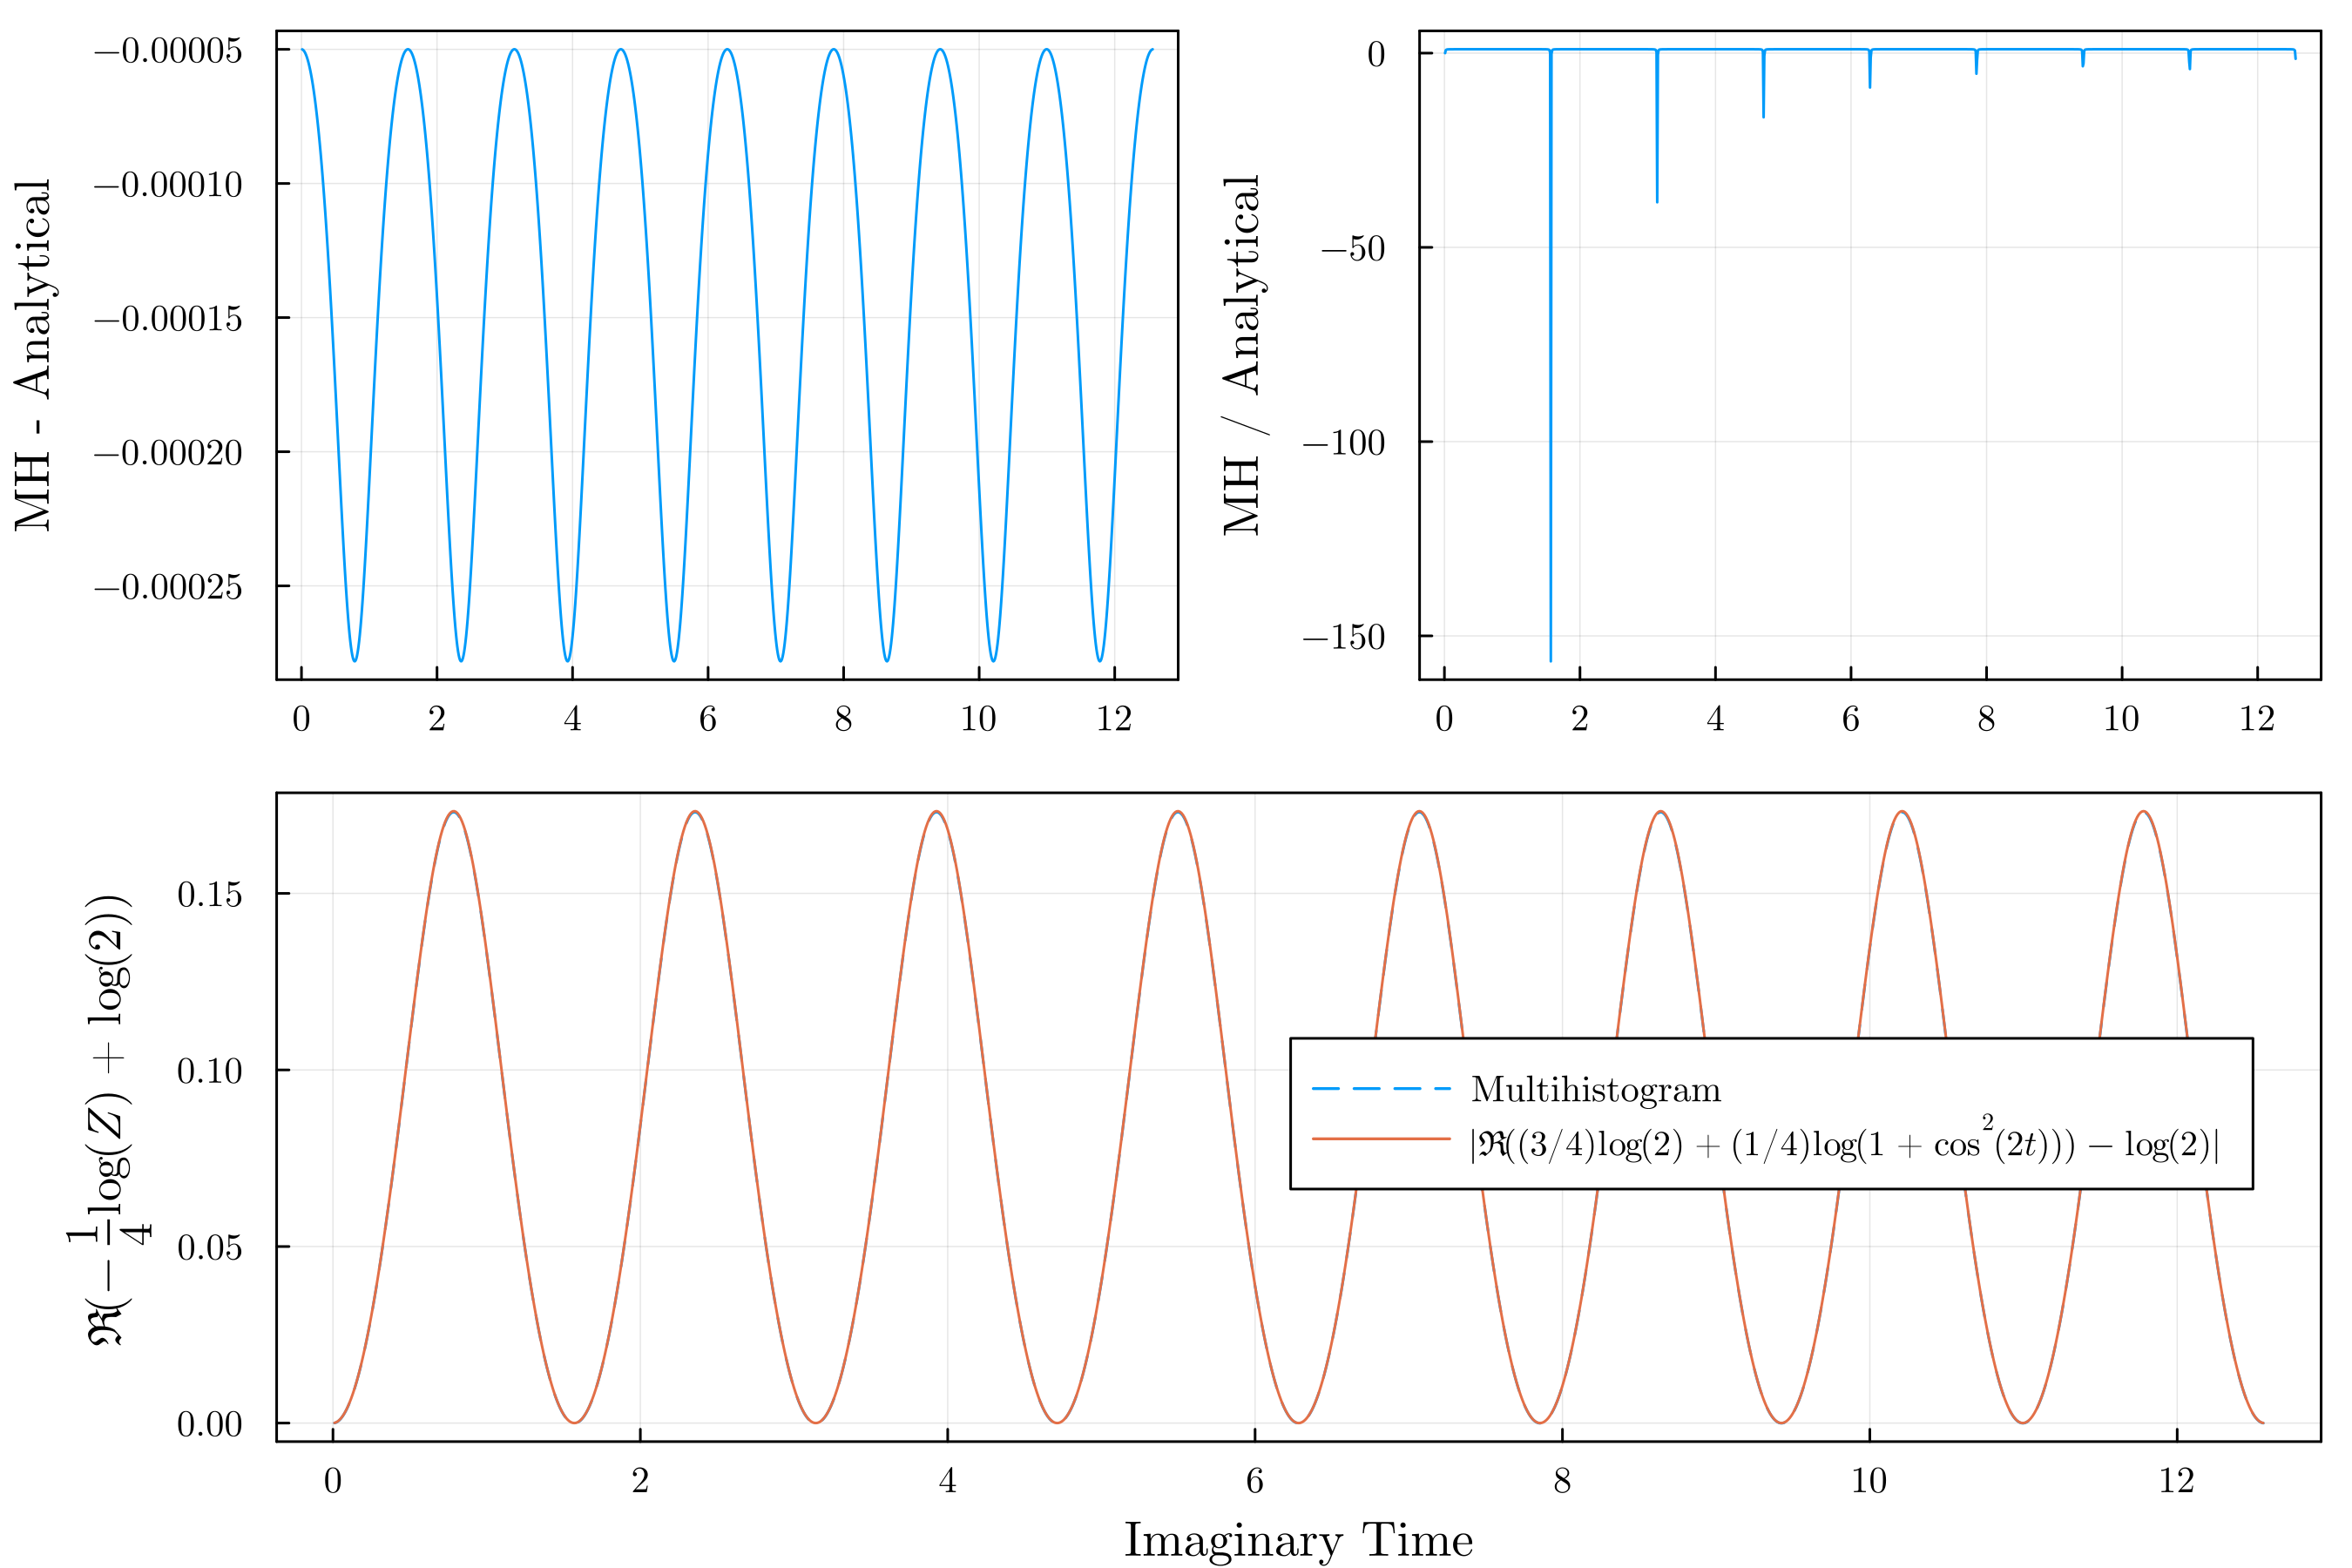

In [29]:
l = @layout [a b ; c]
MH = real.(-1/4 .* DQPT_O1 .+ log(2)) .- real.(-1/4 .* DQPT_O1 .+ log(2))[1]
AN = (x -> analytical_dqpt(x, 1)).(imrange)

fig1 = plot(imrange, MH, label = "Multihistogram", ylabel = L"\Re(-\frac{1}{4} \log(Z) + \log(2))", xlabel = "Imaginary Time", legend = :right, linestyle = :dash)
plot!(fig1, imrange, AN, label = L"|\Re( (3/4) \log(2) + (1/4) \log(1 + \cos^2(2t)) ) - \log(2)|")

diff_fig = plot(imrange, MH .- AN, ylabel = "MH - Analytical")
ratio_fig = plot(imrange, MH ./ AN, ylabel = "MH / Analytical")
order1 = plot(diff_fig, ratio_fig, fig1, layout = l)

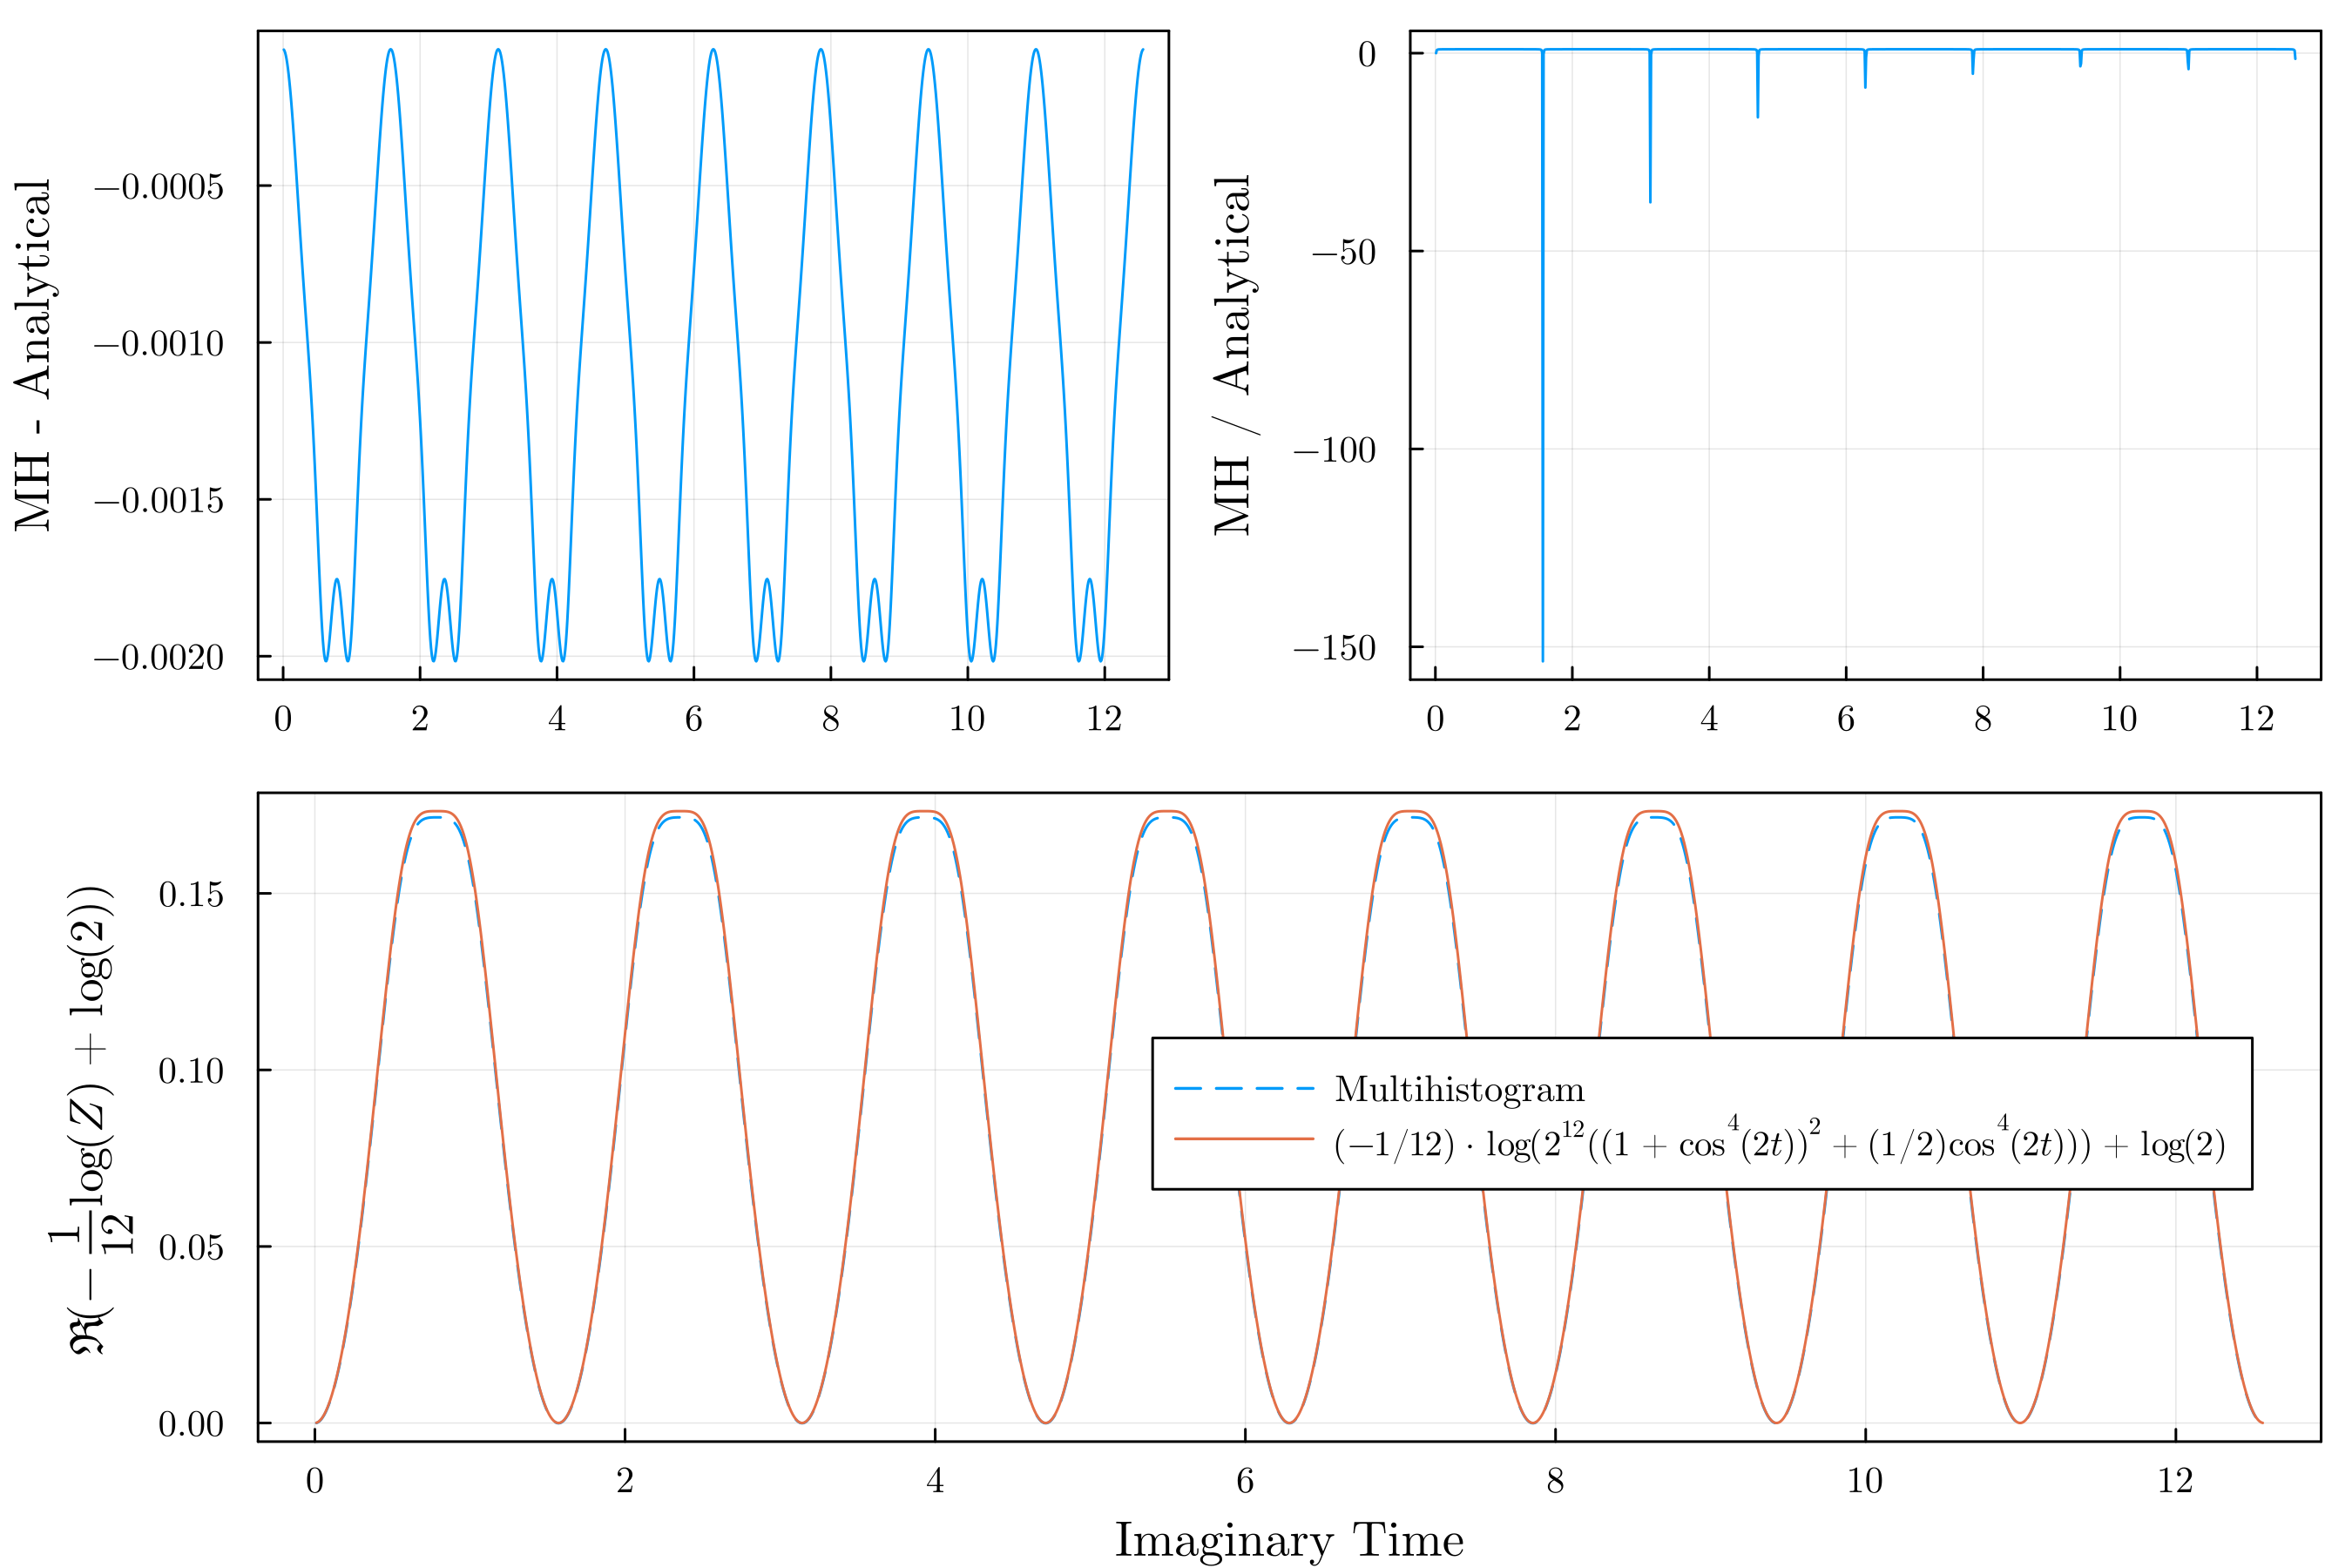

In [30]:
l = @layout [a b ; c]
MH = real.(-1/12 .* DQPT_O2 .+ log(2)) .- real.(-1/12 .* DQPT_O2 .+ log(2))[1]
AN = (x -> analytical_dqpt(x, 2)).(imrange)

fig1 = plot(imrange, MH, label = "Multihistogram", ylabel = L"\Re(-\frac{1}{12} \log(Z) + \log(2))", xlabel = "Imaginary Time", legend = :right, linestyle = :dash)
plot!(fig1, imrange, AN, label = L"(-1/12) \cdot \log(2^{12} ((1+\cos^4(2t))^2 + (1/2) \cos^4(2t))  ) + \log(2)")

diff_fig = plot(imrange, MH .- AN, ylabel = "MH - Analytical")
ratio_fig = plot(imrange, MH ./ AN, ylabel = "MH / Analytical")
order2 = plot(diff_fig, ratio_fig, fig1, layout = l)

In [161]:
savefig(order1, "order1.png")
savefig(order2, "order2.png")

"/home/cocoa_ug22/hierarchical_lattice_runs/order2.png"

Lets also plot the density of states to see how good of an estimate we have. Remember - we know the the density of states must be symmetric.

In [31]:
function gv(dict, key, default)
    if key in keys(dict)
        return dict[key]
    else
        return default
    end
end
function ρ(E, MHData, Edicts, ulim)
    Z = exp.(MHData.free_energies)
    Tvec = MHData.parameter_values
    J = min(length(MHData.parameter_values), ulim)
    total = 0
    num = sum([gv(Edicts[i], E, 0) for i in 1:J])
    den = [exp.(-MHData.free_energies[j]-((1/Tvec[j])*E)) for j in 1:J]
    return num/MultihistogramAnalysis.logsum(den)
end

ρ (generic function with 1 method)

Also we can see how good of an estimate of the DoS we get if we cut off the number of simulations at some index. Change `cutoff_idx` to cut off simulations up till this index. For reference, here is the mapping of index to temperature

In [34]:
temp_to_ind = Dict(Trange .=> eachindex(Trange)) |> sort

OrderedCollections.OrderedDict{Float64, Int64} with 46 entries:
  1.0 => 1
  1.2 => 2
  1.4 => 3
  1.6 => 4
  1.8 => 5
  2.0 => 6
  2.2 => 7
  2.4 => 8
  2.6 => 9
  2.8 => 10
  3.0 => 11
  3.2 => 12
  3.4 => 13
  3.6 => 14
  3.8 => 15
  4.0 => 16
  4.2 => 17
  4.4 => 18
  4.6 => 19
  4.8 => 20
  5.0 => 21
  5.2 => 22
  5.4 => 23
  5.6 => 24
  5.8 => 25
  ⋮   => ⋮

In [35]:
cutoff_idx = 46
MHData2_cutoff = MultihistogramData(2, collect(Trange)[1:cutoff_idx], O2_hists[1:cutoff_idx])
calculate_free_energies!(MHData2_cutoff)

[ Info: Generating marginal histograms and tuple iterators
Minimizing:  Time: 0:00:00 (42 iterations)19)


46-element Vector{Float64}:
 12.21950059818483
  9.763972428764431
  8.157177014518282
  7.082336088391164
  6.344458270991617
  5.822194657251767
  5.440945865736877
  5.1546668927894
  4.934342192664376
  4.761156243352983
  4.622535022132519
  4.509833089301838
  4.416951333775795
  ⋮
  3.8447880311857814
  3.8382801061447207
  3.832244707225626
  3.8266370767853877
  3.821417640490402
  3.8165513026465017
  3.812006850897467
  3.807756451302486
  3.803775218435209
  3.8000408480229595
  3.7965333019343217
  3.793234537155292

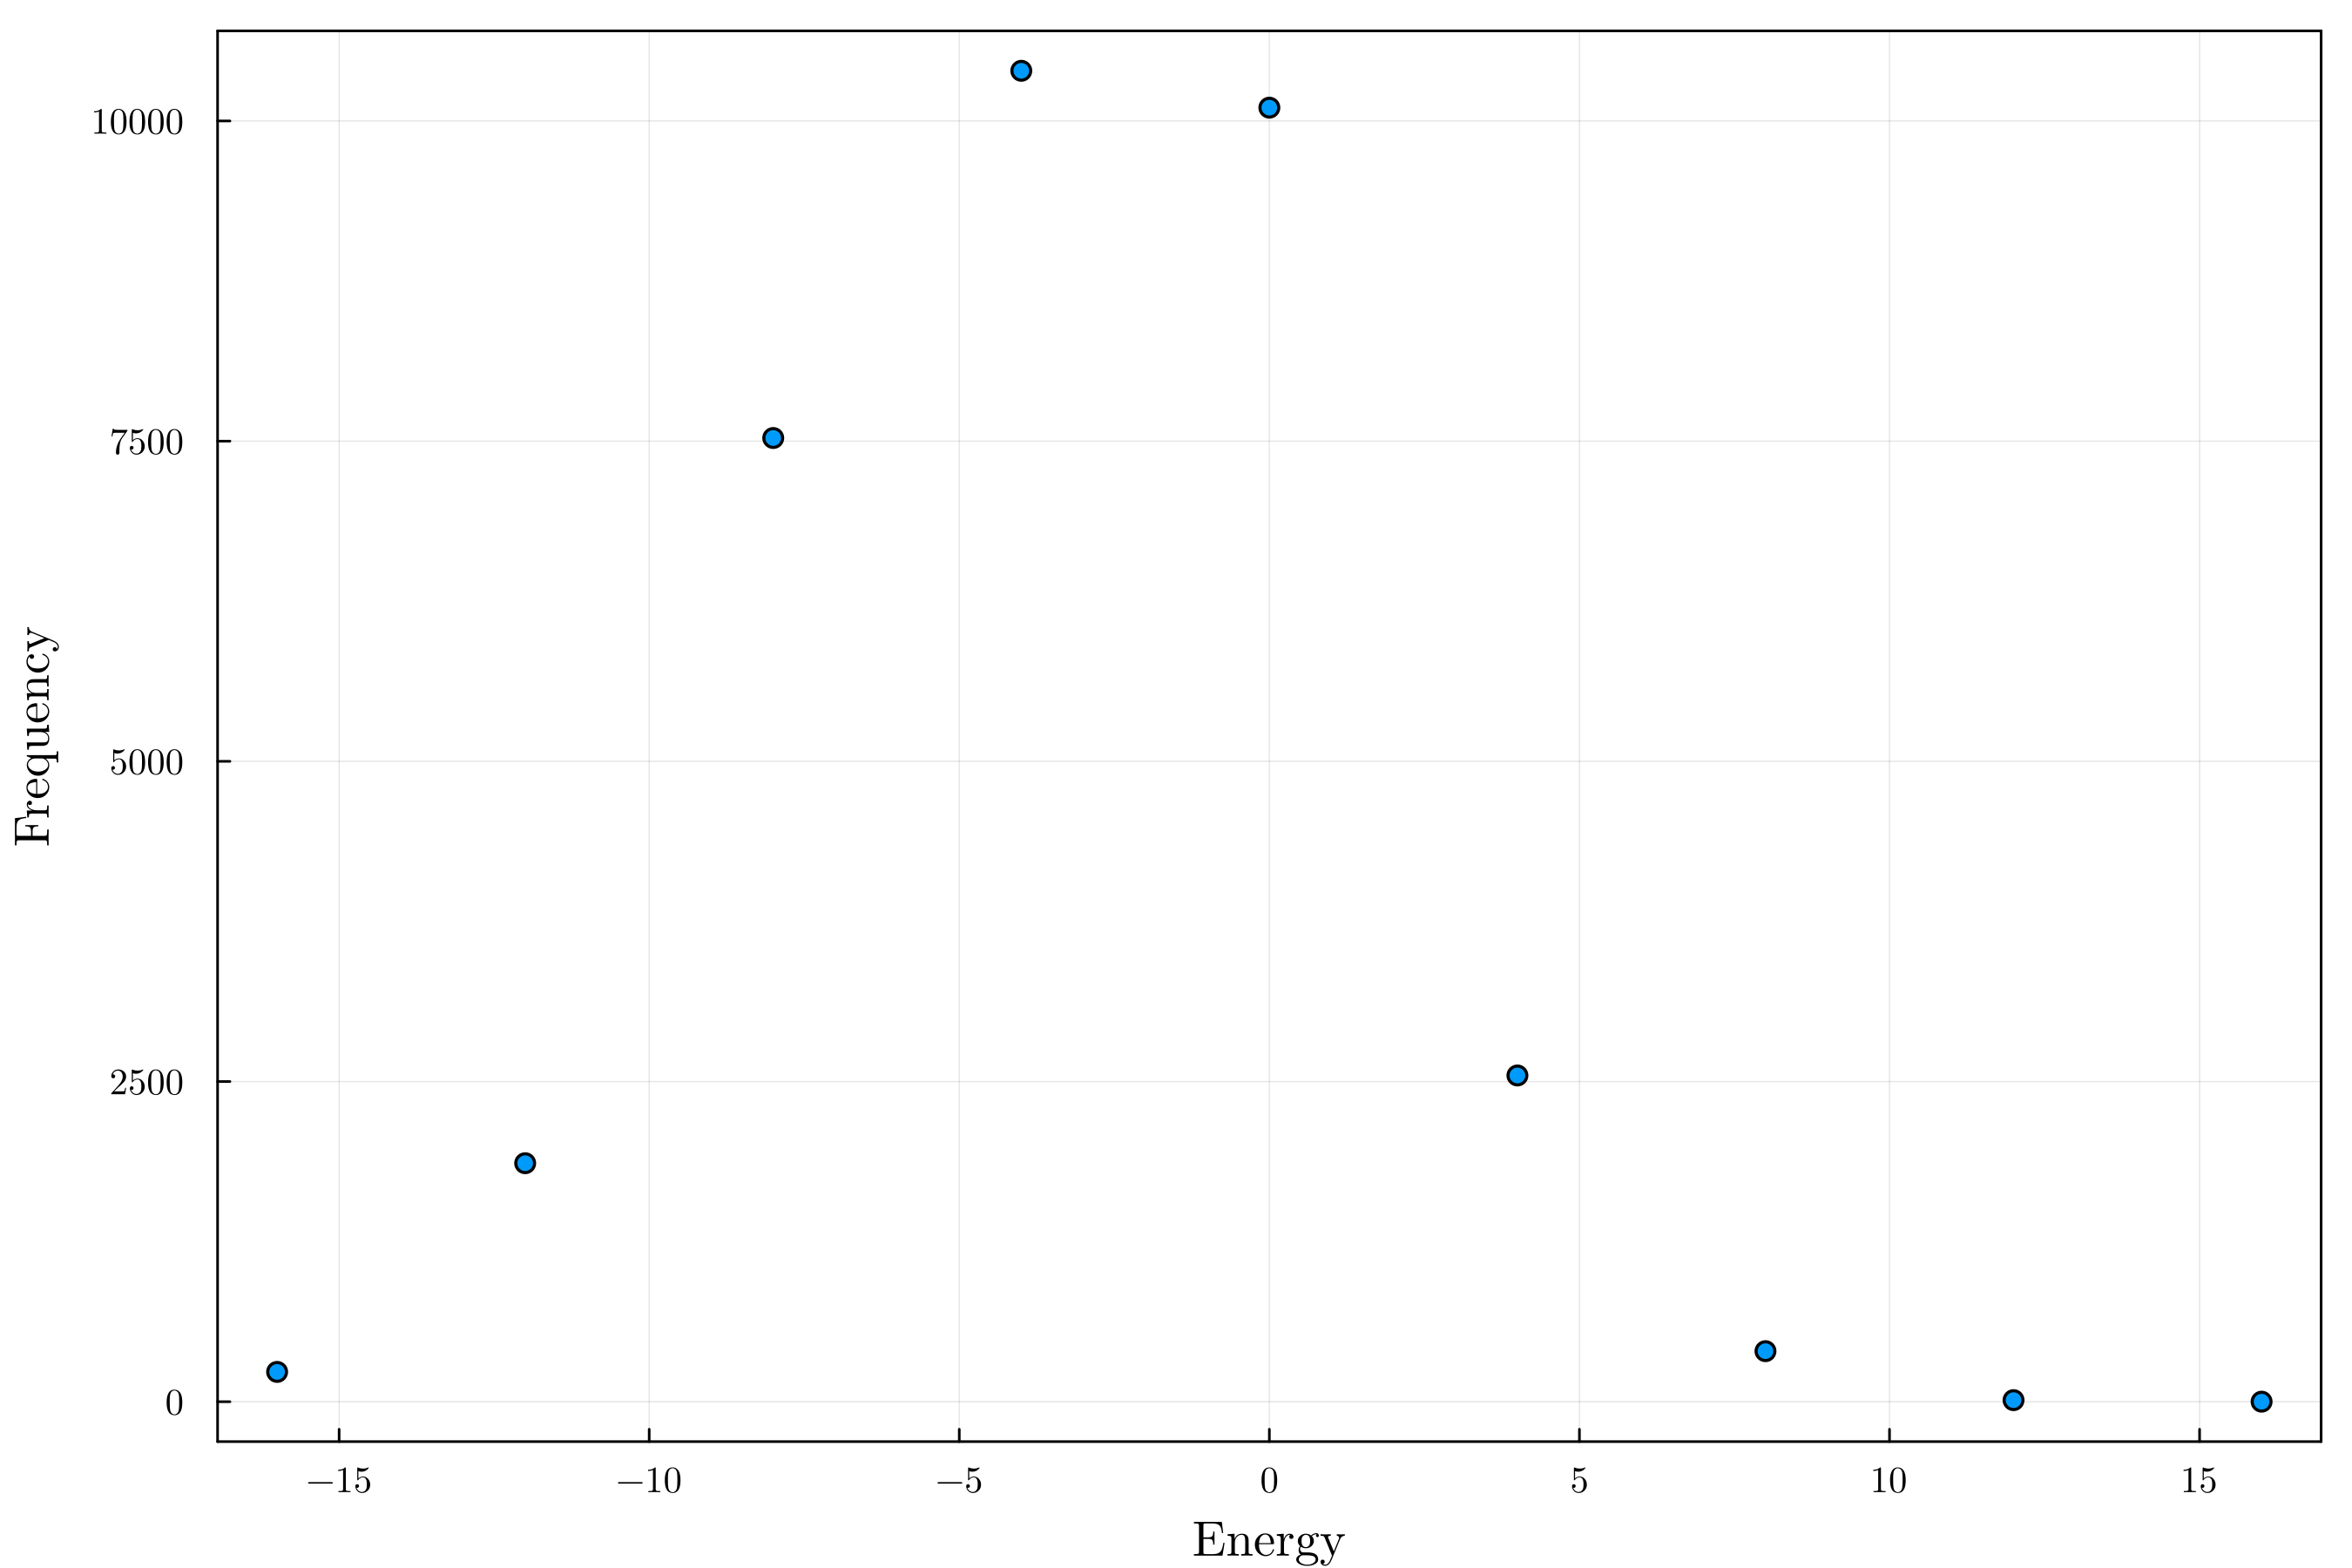

In [36]:
let
    n = cutoff_idx
    Edicts = Dict.(pairs.(MHData2.marginal_energy_histograms[1:n]))
    Erange = -16:4:16
    f(E) = ρ(E, MHData2, Edicts, n)
    scatter(Erange, f.(Erange), xlabel = "Energy", ylabel = "Frequency")
end

What if we force the density of states to be symmetric?

In [37]:
function logsum(logterms::Vector{ComplexF64})
    lr = real.(logterms)
    maxidx = findfirst(==(maximum(lr)), lr)
    maxterm = logterms[maxidx]
    logterms_filtered = filter(x -> x != maxterm, logterms)
    return maxterm + log1p(sum(exp.(logterms_filtered .- maxterm)))
end
function logsum(logterms)
    lm = maximum(logterms)
    logterms_removed = filter(!=(lm), logterms)
    return lm + log1p(sum(exp.(logterms_removed .- lm)))
end
function interpolate_free_energy_logsum_sym(parameter_value::T, data::MultihistogramData; isbeta = false) where T
    if !isbeta
        β = 1/parameter_value
    else
        β = parameter_value
    end
    
    Tvec = data.parameter_values
    Evec = data.marginal_energy_histograms
    u    = data.free_energies
    J    = length(Tvec)
    A    = -1/2 * (maximum(u) + minimum(u))
    nterms = sum([length(H) for H in Evec])
    
    logterms = zeros(T, 2nterms)
    offset = 0
    for i in 1:J
        iterthing = collect(pairs(Evec[i]))

        Threads.@threads for idx in 1:length(iterthing)
            E = first(iterthing[idx])
            f = last(iterthing[idx])
            logterms[offset + idx] = log(f) - logsum([
                -A-u[j]+(β - 1/Tvec[j])*E for j in 1:J
            ])
            logterms[offset + nterms + idx] = log(f) - logsum([
                -A-u[j]-(β - 1/Tvec[j])*E for j in 1:J
            ])
        end

        offset += length(iterthing)
    end

    return logsum(logterms)
end

interpolate_free_energy_logsum_sym (generic function with 1 method)

In [38]:
DQPT_O2_cutoff = (x -> interpolate_free_energy(x, MHData2_cutoff, isbeta = true)).(imrange .* 1im)
DQPT_O2_cutoff_sym = (x -> interpolate_free_energy_logsum_sym(x, MHData2_cutoff, isbeta = true)).(imrange .* 1im)

1256-element Vector{ComplexF64}:
  5.378958553686951 - 0.07260283447148216im
  5.372907616417186 - 0.14523454318332518im
  5.362798719229888 - 0.21792385395409114im
  5.348595316534858 - 0.2906991921000055im
  5.330245132679738 - 0.36358850423057615im
  5.307678987675989 - 0.43661904974224486im
  5.280809192514098 - 0.5098171449938256im
  5.249527432153101 - 0.5832078408076389im
  5.213702022437069 - 0.6568145074914119im
 5.1731743844366065 - 0.7306582920566298im
  5.127754520851463 - 0.8047573981923432im
   5.07721519630525 - 0.8791261183865624im
  5.021284404496512 - 0.9537735153577402im
                    ⋮
 5.0961658097897455 - 200.20982685928138im
   5.14481817502562 - 200.28409637052363im
  5.188438289392046 - 200.35810092865185im
  5.227239102892478 - 200.4318563770193im
  5.261398612723582 - 200.50538208461458im
  5.291065171556236 - 200.5787000780362im
  5.316361619448989 - 200.65183439265812im
  5.337388504094125 - 200.72481058108582im
   5.35422658111225 - 200.7976553352461

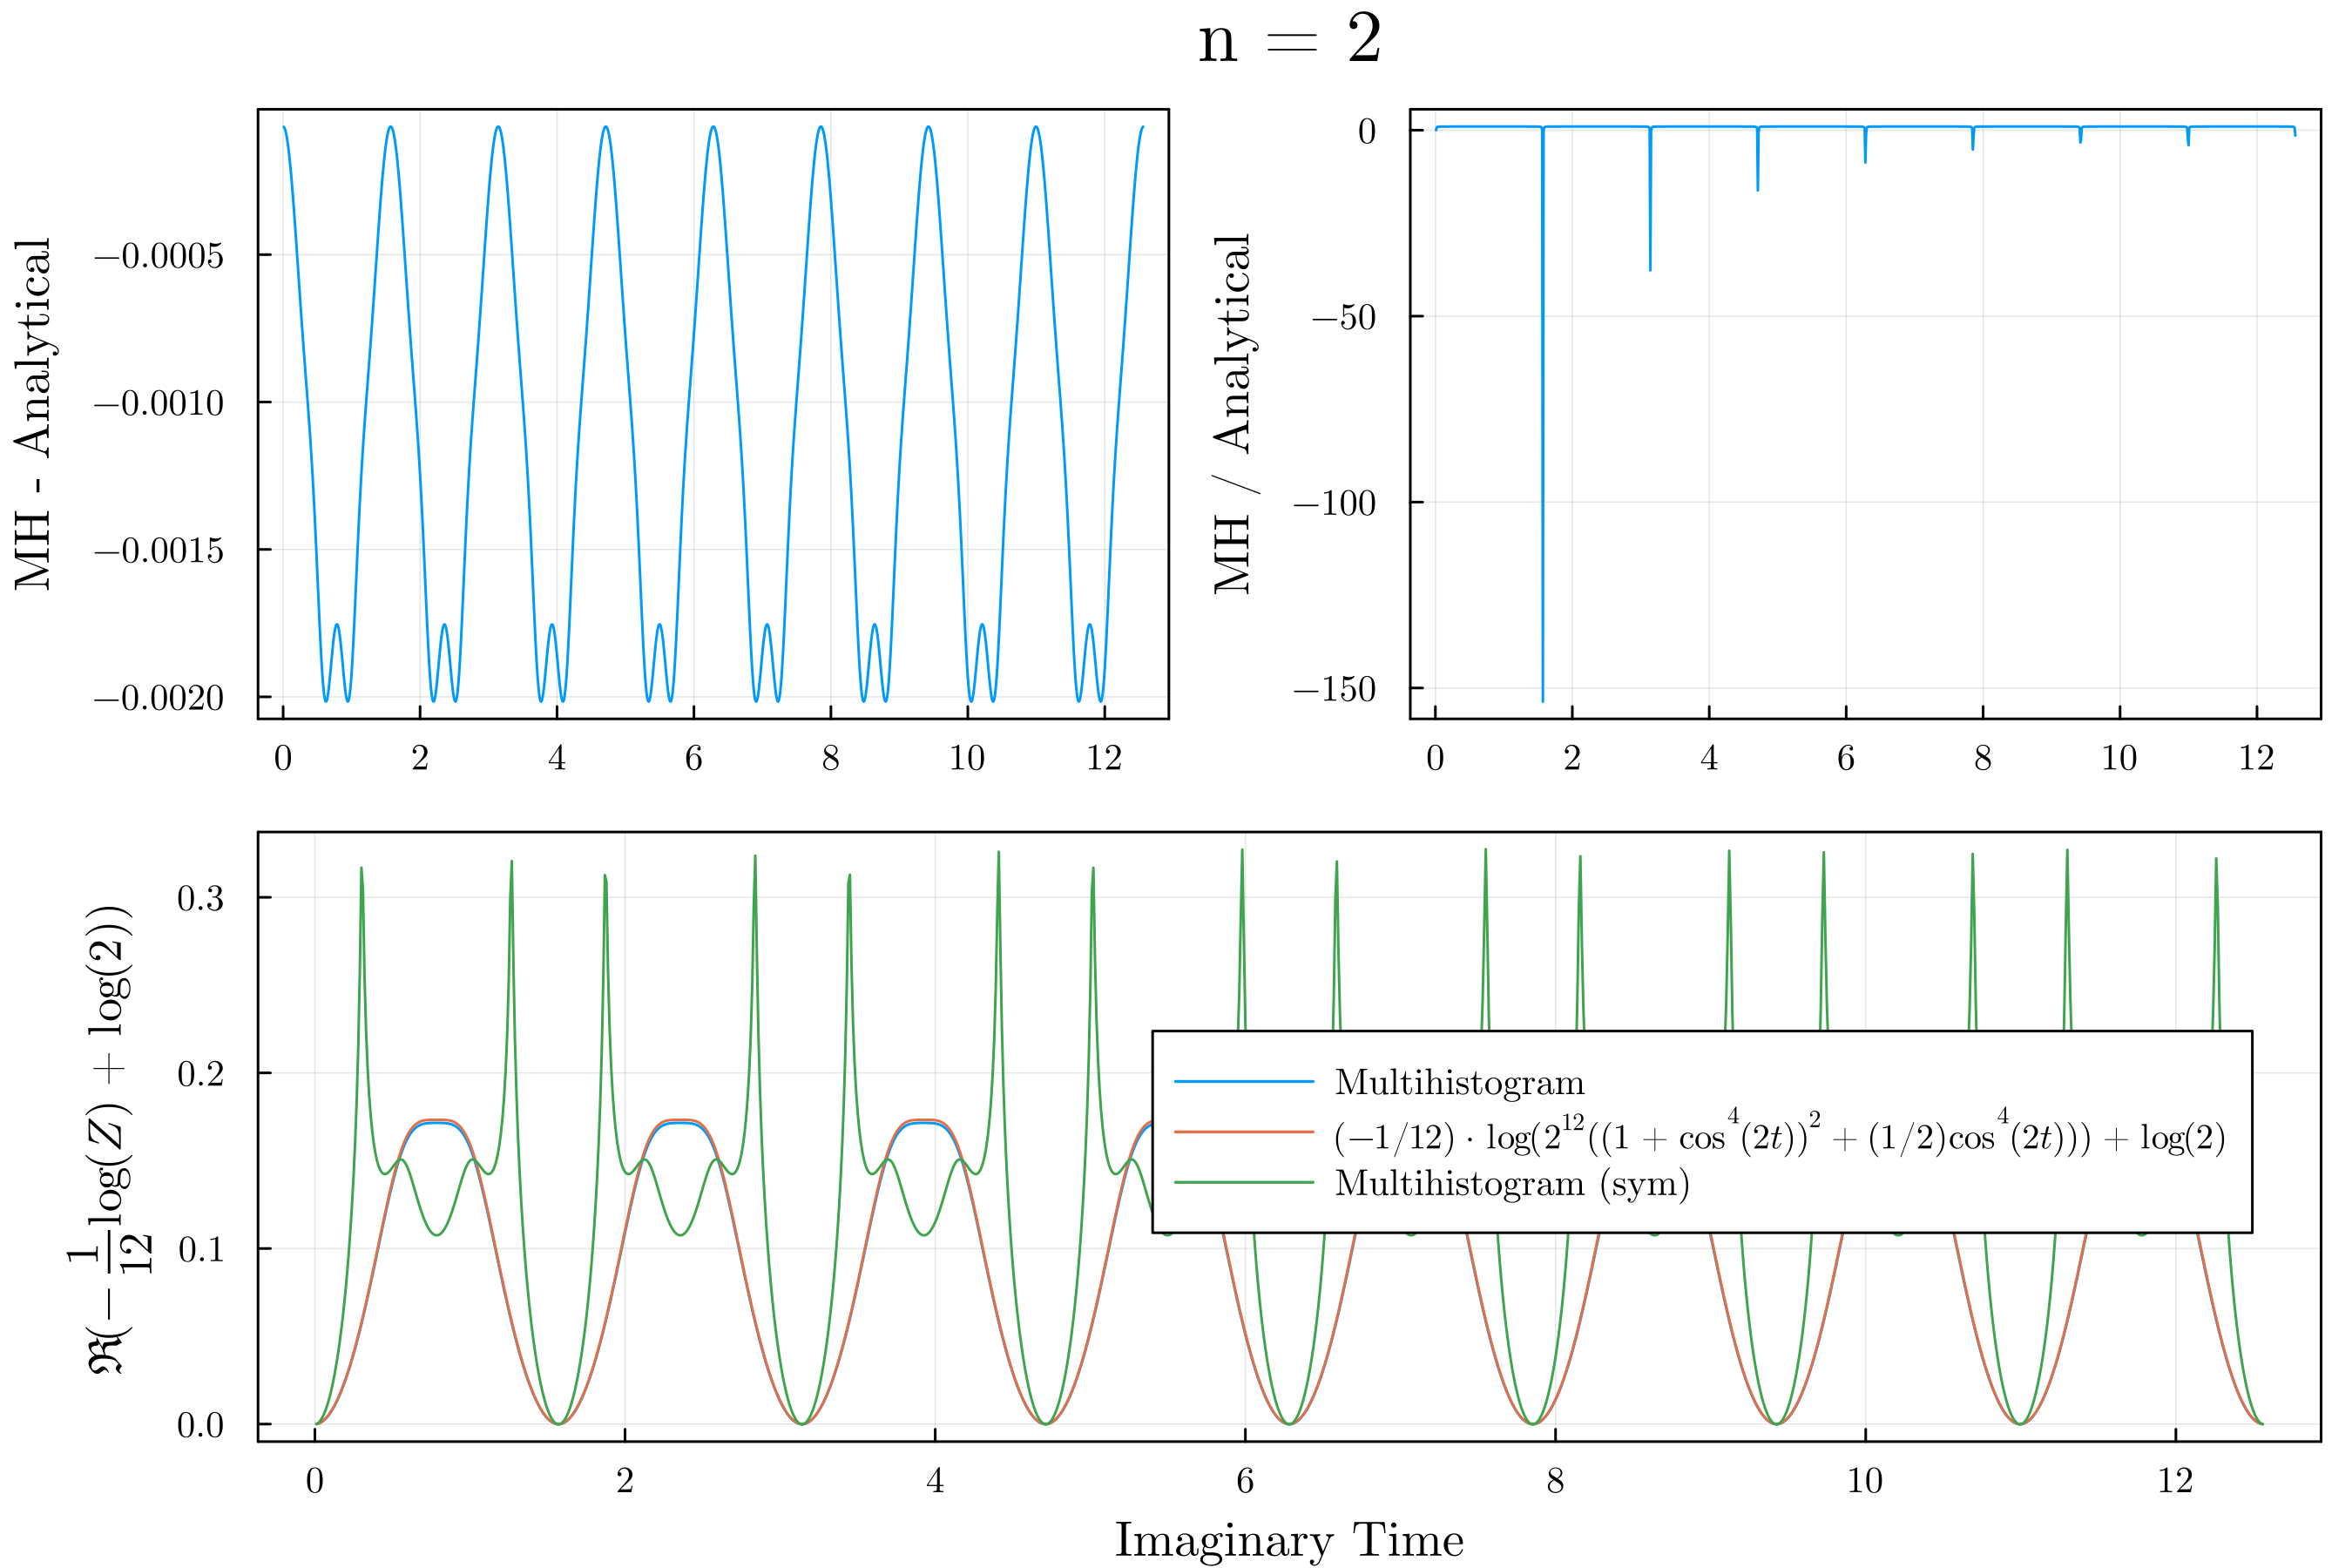

In [39]:
l = @layout [a b ; c]
MH = real.(-1/12 .* DQPT_O2_cutoff .+ log(2)) .- real.(-1/12 .* DQPT_O2_cutoff .+ log(2))[1]
MH_sym = real.(-1/12 .* DQPT_O2_cutoff_sym .+ log(2)) .- real.(-1/12 .* DQPT_O2_cutoff_sym .+ log(2))[1]
AN = (x -> analytical_dqpt(x, 2)).(imrange)

fig1 = plot(imrange, MH, label = "Multihistogram", ylabel = L"\Re(-\frac{1}{12} \log(Z) + \log(2))", xlabel = "Imaginary Time", legend = :right)
plot!(fig1, imrange, AN, label = L"(-1/12) \cdot \log(2^{12} ((1+\cos^4(2t))^2 + (1/2) \cos^4(2t))  ) + \log(2)")
plot!(fig1, imrange, MH_sym, label = "Multihistogram (sym)")

diff_fig = plot(imrange, MH .- AN, ylabel = "MH - Analytical")
ratio_fig = plot(imrange, MH ./ AN, ylabel = "MH / Analytical")
order2 = plot(diff_fig, ratio_fig, fig1, layout = l, plot_title = "n = 2")

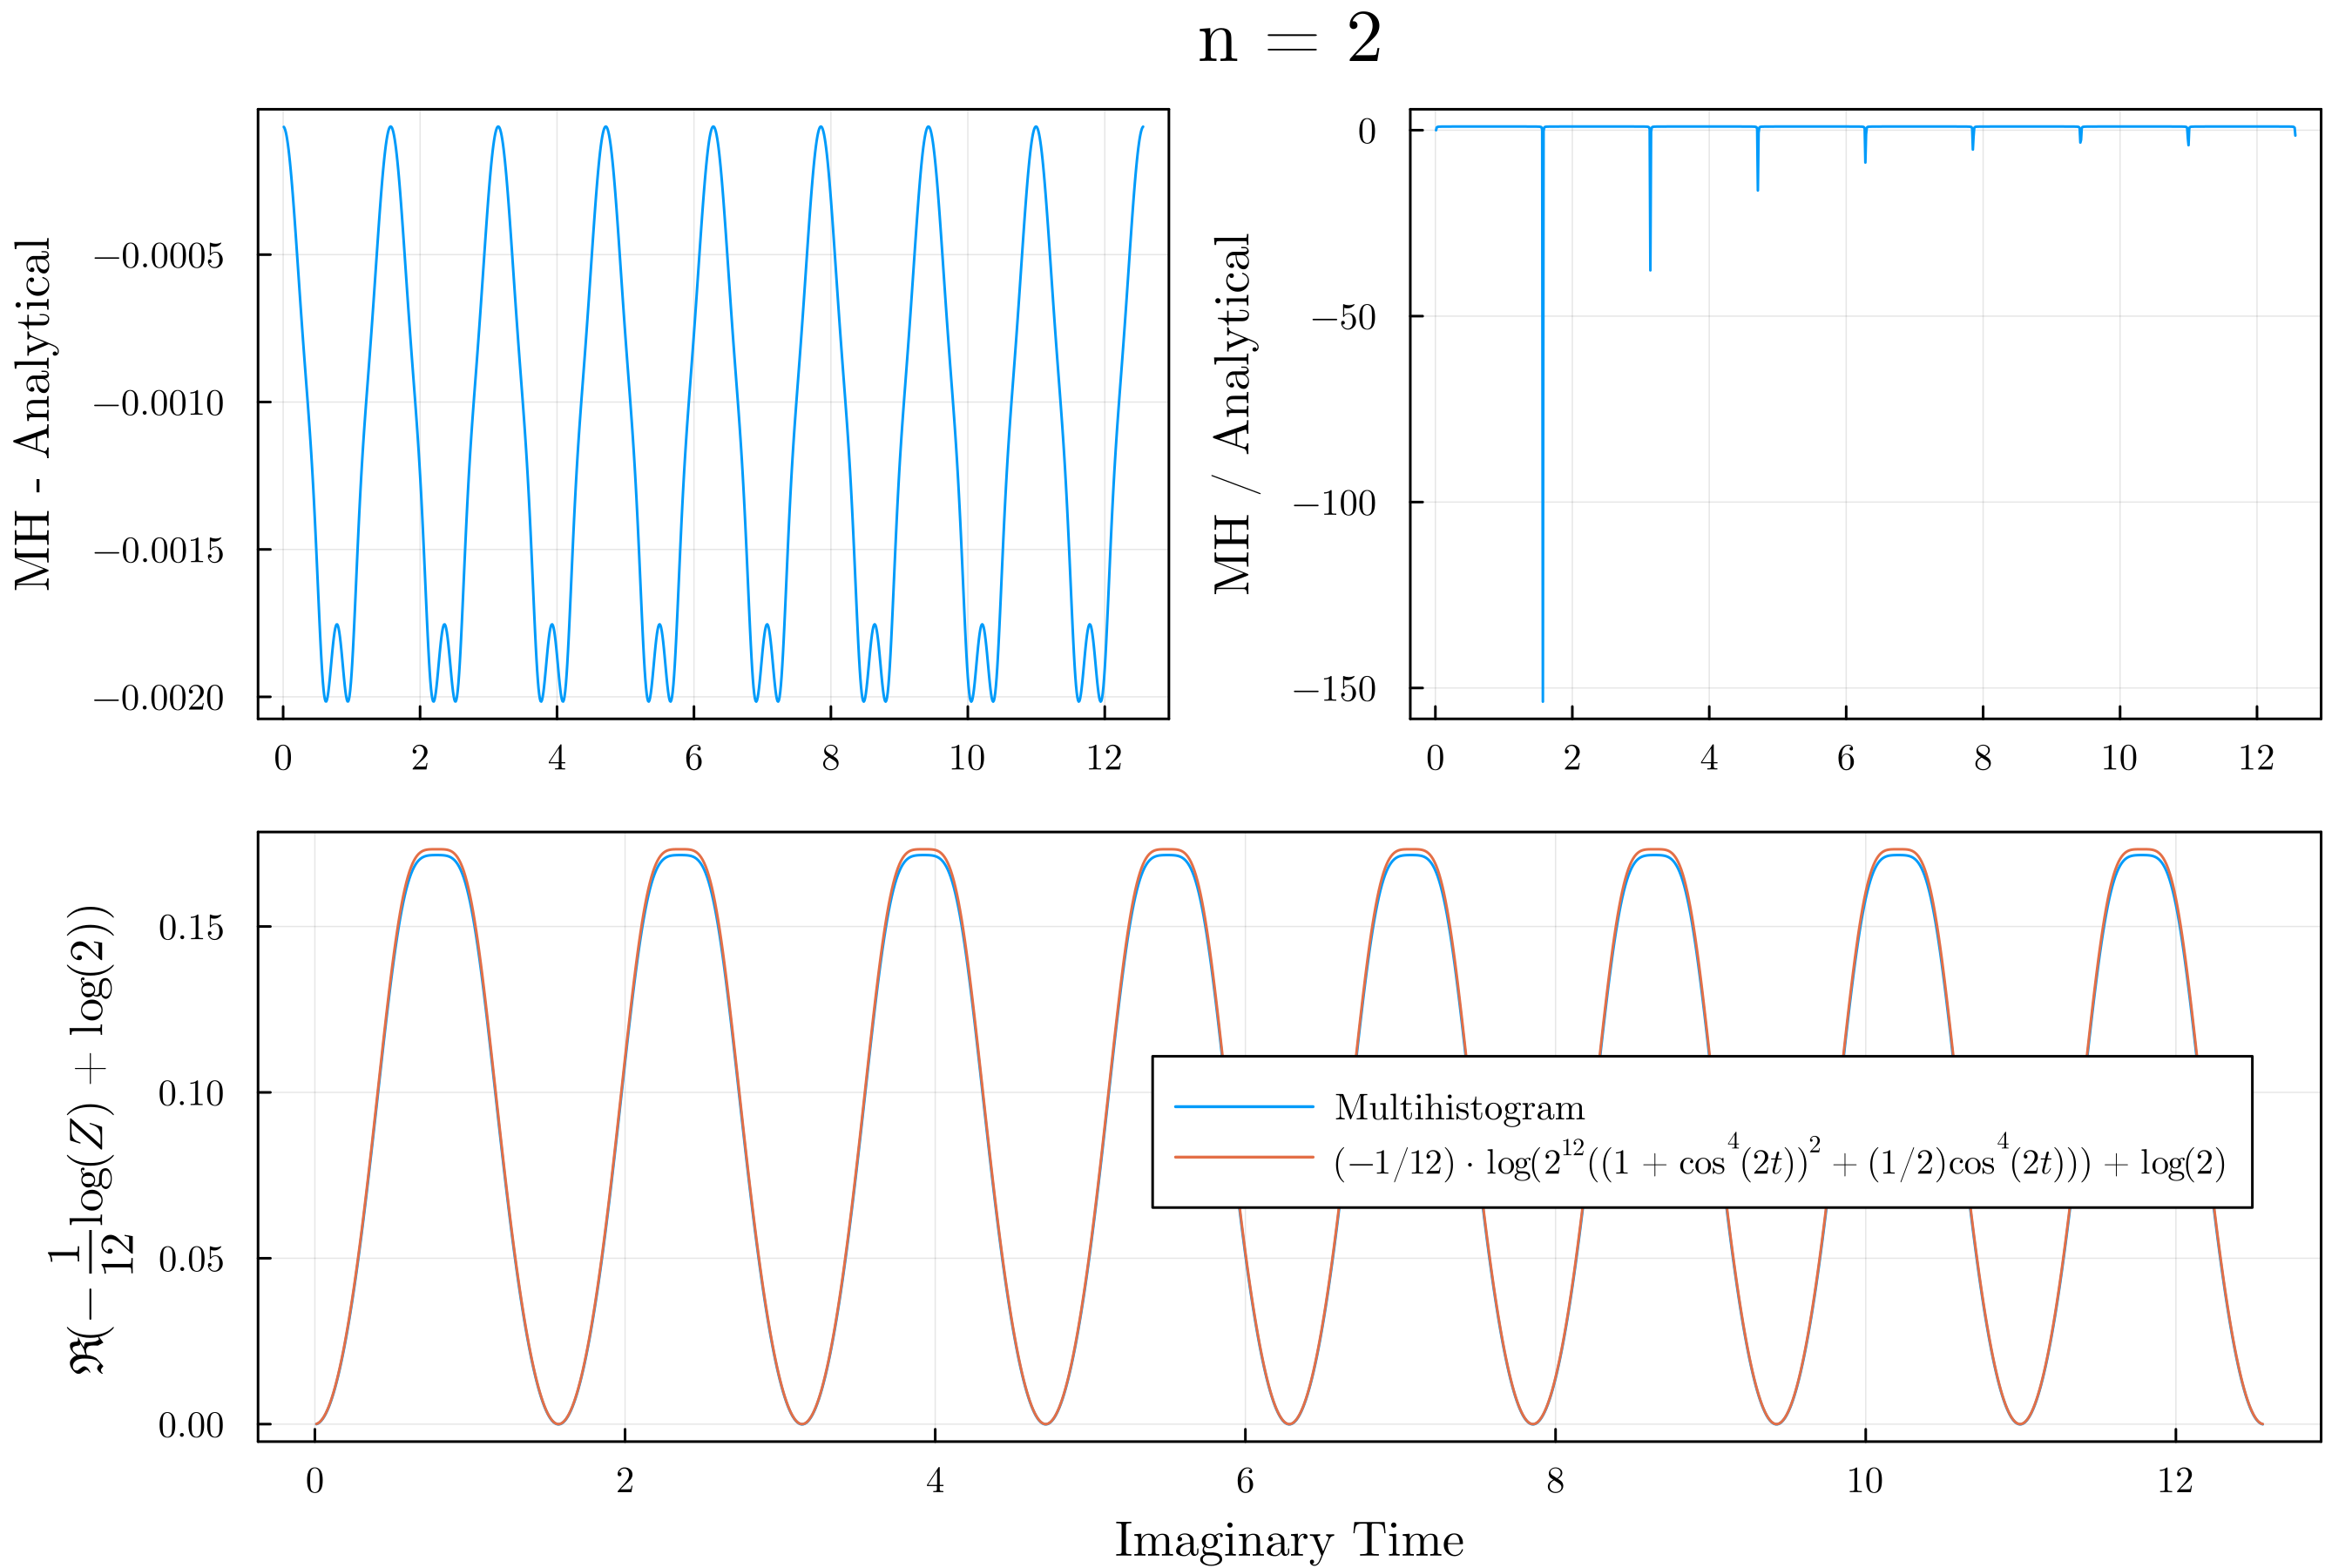

In [40]:
l = @layout [a b ; c]
MH = real.(-1/12 .* DQPT_O2 .+ log(2)) .- real.(-1/12 .* DQPT_O2 .+ log(2))[1]
AN = (x -> analytical_dqpt(x, 2)).(imrange)

fig1 = plot(imrange, MH, label = "Multihistogram", ylabel = L"\Re(-\frac{1}{12} \log(Z) + \log(2))", xlabel = "Imaginary Time", legend = :right)
plot!(fig1, imrange, AN, label = L"(-1/12) \cdot \log(2^{12} ((1+\cos^4(2t))^2 + (1/2) \cos^4(2t))  ) + \log(2)")

diff_fig = plot(imrange, MH .- AN, ylabel = "MH - Analytical")
ratio_fig = plot(imrange, MH ./ AN, ylabel = "MH / Analytical")
order2 = plot(diff_fig, ratio_fig, fig1, layout = l, plot_title = "n = 2")

In [228]:
savefig(order0, "order0.png")
savefig(order1, "order1.png")
savefig(order2, "order2.png")

"/home/cocoa_ug22/hierarchical_lattice_runs/order2.png"